# Knowledge Distillation Experiments - CUDA

**Thesis: Knowledge Distillation for LLMs**

## Setup
1. Runtime > Change runtime type > **GPU** (T4 or better)
2. Run all cells in order
3. Results saved to Google Drive

In [1]:
import torch
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    raise RuntimeError('No GPU! Runtime > Change runtime type > GPU')

CUDA available: True
GPU: NVIDIA H100 80GB HBM3
Memory: 85.2 GB


In [2]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/thesis-kd'
!mkdir -p {PROJECT_DIR}

Mounted at /content/drive


In [3]:
!pip install -q transformers>=4.40.0 datasets>=2.18.0 peft>=0.10.0 accelerate>=0.28.0 scipy scikit-learn tqdm matplotlib seaborn pandas

In [4]:
import os, gc, json, time
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

ROOT = Path('/content/kd_exp')
for d in ['models', 'runs', 'figures', 'cache']:
    (ROOT / d).mkdir(parents=True, exist_ok=True)

DEVICE = torch.device('cuda')
print(f'Root: {ROOT}')

Root: /content/kd_exp


In [5]:
CONFIG = {
    'teacher': 'Qwen/Qwen2.5-3B-Instruct',
    'student': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
    'train_n': 5000, 'val_n': 1000,
    'batch': 4, 'grad_accum': 4, 'epochs': 3, 'lr': 2e-4,
    'fp16': True, 'lora_r': 16, 'lora_alpha': 32,
    'seeds': [42, 123, 456]
}
print(CONFIG)

{'teacher': 'Qwen/Qwen2.5-3B-Instruct', 'student': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'train_n': 5000, 'val_n': 1000, 'batch': 4, 'grad_accum': 4, 'epochs': 3, 'lr': 0.0002, 'fp16': True, 'lora_r': 16, 'lora_alpha': 32, 'seeds': [42, 123, 456]}


## Step 1: Load Datasets

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

sst2 = load_dataset('glue', 'sst2')
squad = load_dataset('squad')

sst2_train = sst2['train'].select(range(min(CONFIG['train_n'], len(sst2['train']))))
sst2_val = sst2['validation']
squad_train = squad['train'].select(range(min(CONFIG['train_n'], len(squad['train']))))
squad_val = squad['validation'].select(range(min(CONFIG['val_n'], len(squad['validation']))))

print(f'SST-2: {len(sst2_train)} train, {len(sst2_val)} val')
print(f'SQuAD: {len(squad_train)} train, {len(squad_val)} val')

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

SST-2: 5000 train, 872 val
SQuAD: 5000 train, 1000 val


In [7]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG['student'], trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def make_sst2(ex):
    lab = 'positive' if ex['label'] == 1 else 'negative'
    return {'prompt': f"Classify: {ex['sentence']}\nSentiment: {lab}"}

def make_squad(ex):
    ans = ex['answers']['text'][0] if ex['answers']['text'] else ''
    return {'prompt': f"Context: {ex['context'][:500]}\nQ: {ex['question']}\nA: {ans}"}

sst2_train = sst2_train.map(make_sst2)
sst2_val = sst2_val.map(make_sst2)
squad_train = squad_train.map(make_squad)
squad_val = squad_val.map(make_squad)
print('Prompts created!')

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Prompts created!


In [8]:
def tokenize(ex, max_len=256):
    enc = tokenizer(ex['prompt'], truncation=True, max_length=max_len, padding='max_length')
    enc['labels'] = enc['input_ids'].copy()
    return enc

sst2_train_tok = sst2_train.map(lambda x: tokenize(x, 256), batched=True, remove_columns=sst2_train.column_names)
sst2_val_tok = sst2_val.map(lambda x: tokenize(x, 256), batched=True, remove_columns=sst2_val.column_names)
squad_train_tok = squad_train.map(lambda x: tokenize(x, 512), batched=True, remove_columns=squad_train.column_names)
squad_val_tok = squad_val.map(lambda x: tokenize(x, 512), batched=True, remove_columns=squad_val.column_names)
print('Tokenization done!')

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization done!


## Step 2: Cache Teacher Outputs

In [9]:
teacher = AutoModelForCausalLM.from_pretrained(CONFIG['teacher'], trust_remote_code=True, torch_dtype=torch.float16, device_map='auto')
teacher.eval()
teacher_tok = AutoTokenizer.from_pretrained(CONFIG['teacher'], trust_remote_code=True)
if teacher_tok.pad_token is None:
    teacher_tok.pad_token = teacher_tok.eos_token
print(f"Teacher: {sum(p.numel() for p in teacher.parameters())/1e9:.2f}B")

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Teacher: 3.09B


In [10]:
cache_file = ROOT / 'cache' / 'squad_answers.json'
if cache_file.exists():
    print('Cache exists')
else:
    answers = []
    for i, ex in enumerate(tqdm(squad_train)):
        p = ex['prompt'].split('A:')[0] + 'A:'
        inp = teacher_tok(p, return_tensors='pt', truncation=True, max_length=448)
        inp = {k: v.to(teacher.device) for k, v in inp.items()}
        with torch.no_grad():
            out = teacher.generate(**inp, max_new_tokens=64, do_sample=False, pad_token_id=teacher_tok.pad_token_id)
        a = teacher_tok.decode(out[0][inp['input_ids'].shape[1]:], skip_special_tokens=True)
        answers.append({'prompt': p, 'answer': a})
        if i % 100 == 0: torch.cuda.empty_cache()
    with open(cache_file, 'w') as f: json.dump(answers, f)
    print(f'Saved {len(answers)}')

  0%|          | 0/5000 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 5000


In [11]:
del teacher
torch.cuda.empty_cache()
gc.collect()
print('Teacher unloaded')

Teacher unloaded


## Step 3: Training Functions

In [12]:
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

def load_student():
    m = AutoModelForCausalLM.from_pretrained(CONFIG['student'], trust_remote_code=True, torch_dtype=torch.float16)
    lora = LoraConfig(task_type=TaskType.CAUSAL_LM, r=CONFIG['lora_r'], lora_alpha=CONFIG['lora_alpha'], target_modules=['q_proj','k_proj','v_proj','o_proj'])
    m = get_peft_model(m, lora)
    m.print_trainable_parameters()
    return m.to(DEVICE)

def get_args(out, name):
    return TrainingArguments(output_dir=str(out), run_name=name, num_train_epochs=CONFIG['epochs'],
        per_device_train_batch_size=CONFIG['batch'], gradient_accumulation_steps=CONFIG['grad_accum'],
        learning_rate=CONFIG['lr'], fp16=CONFIG['fp16'], logging_steps=50, eval_strategy='epoch',
        save_strategy='epoch', save_total_limit=1, load_best_model_at_end=True, report_to='none')

print('Ready!')

Ready!


## Step 4: Run Experiments

In [13]:
MODELS = ROOT / 'models'
RUNS = ROOT / 'runs'
results = []

In [14]:
print('='*60)
print('B0: BASELINE')
for seed in CONFIG['seeds']:
    for task, tds, vds in [('sst2', sst2_train_tok, sst2_val_tok), ('squad', squad_train_tok, squad_val_tok)]:
        rid = f'B0_{task}_s{seed}'
        out = MODELS / rid
        if (out / 'final').exists(): print(f'Skip {rid}'); continue
        print(f'Training {rid}')
        torch.manual_seed(seed); np.random.seed(seed)
        m = load_student()
        t = Trainer(model=m, args=get_args(out, rid), train_dataset=tds, eval_dataset=vds, processing_class=tokenizer)
        tr = t.train(); ev = t.evaluate()
        t.save_model(str(out / 'final'))
        results.append({'id': rid, 'method': 'B0', 'task': task, 'seed': seed, 'eval_loss': ev['eval_loss']})
        print(f"Done: {ev['eval_loss']:.4f}")
        del m, t; torch.cuda.empty_cache(); gc.collect()

B0: BASELINE
Training B0_sst2_s42


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.179100,0.320562
2,0.177600,0.314973
3,0.161000,0.319046


Done: 0.3150
Training B0_squad_s42
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.454300,0.523730
2,0.291400,0.621846
3,0.214500,0.711155


Done: 0.5237
Training B0_sst2_s123
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.179100,0.320259
2,0.177800,0.315069
3,0.161200,0.319041


Done: 0.3151
Training B0_squad_s123
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.455100,0.520816
2,0.291800,0.624032
3,0.215000,0.711314


Done: 0.5208
Training B0_sst2_s456
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.179000,0.320170
2,0.177500,0.315129
3,0.160900,0.319179


Done: 0.3151
Training B0_squad_s456
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.452900,0.522245
2,0.290100,0.617515
3,0.214400,0.699131


Done: 0.5222


In [15]:
print('='*60)
print('KD2: SEQUENCE-LEVEL')
with open(ROOT / 'cache' / 'squad_answers.json') as f: ta = json.load(f)
from datasets import Dataset
kd2_prompts = [x['prompt'] + ' ' + x['answer'] for x in ta]
kd2_enc = tokenizer(kd2_prompts, truncation=True, max_length=512, padding='max_length')
kd2_ds = Dataset.from_dict({'input_ids': kd2_enc['input_ids'], 'attention_mask': kd2_enc['attention_mask'], 'labels': kd2_enc['input_ids']})
print(f'KD2: {len(kd2_ds)} examples')

for seed in CONFIG['seeds']:
    rid = f'KD2_squad_s{seed}'
    out = MODELS / rid
    if (out / 'final').exists(): print(f'Skip {rid}'); continue
    print(f'Training {rid}')
    torch.manual_seed(seed); np.random.seed(seed)
    m = load_student()
    t = Trainer(model=m, args=get_args(out, rid), train_dataset=kd2_ds, eval_dataset=squad_val_tok, processing_class=tokenizer)
    tr = t.train(); ev = t.evaluate()
    t.save_model(str(out / 'final'))
    results.append({'id': rid, 'method': 'KD2', 'task': 'squad', 'seed': seed, 'eval_loss': ev['eval_loss']})
    print(f"Done: {ev['eval_loss']:.4f}")
    del m, t; torch.cuda.empty_cache(); gc.collect()

KD2: SEQUENCE-LEVEL
KD2: 5000 examples
Training KD2_squad_s42
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.600700,0.541442
2,0.469000,0.614096
3,0.383200,0.666183


Done: 0.5414
Training KD2_squad_s123
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.600900,0.541891
2,0.467600,0.610611
3,0.381500,0.673011


Done: 0.5419
Training KD2_squad_s456
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.599600,0.543843
2,0.464700,0.608782
3,0.378200,0.671625


Done: 0.5438


In [16]:
df = pd.DataFrame(results)
df.to_csv(RUNS / 'results.csv', index=False)
print(df)

               id method   task  seed  eval_loss
0     B0_sst2_s42     B0   sst2    42   0.314973
1    B0_squad_s42     B0  squad    42   0.523730
2    B0_sst2_s123     B0   sst2   123   0.315069
3   B0_squad_s123     B0  squad   123   0.520816
4    B0_sst2_s456     B0   sst2   456   0.315129
5   B0_squad_s456     B0  squad   456   0.522245
6   KD2_squad_s42    KD2  squad    42   0.541442
7  KD2_squad_s123    KD2  squad   123   0.541891
8  KD2_squad_s456    KD2  squad   456   0.543843


## Step 5: Benchmarking

In [17]:
def bench(model, n=20):
    inp = tokenizer('The quick brown fox', return_tensors='pt').to(DEVICE)
    for _ in range(5):
        with torch.no_grad(): model.generate(**inp, max_new_tokens=32, do_sample=False, pad_token_id=tokenizer.pad_token_id)
    torch.cuda.synchronize()
    lats = []
    for _ in range(n):
        s = time.perf_counter()
        with torch.no_grad(): model.generate(**inp, max_new_tokens=32, do_sample=False, pad_token_id=tokenizer.pad_token_id)
        torch.cuda.synchronize()
        lats.append((time.perf_counter() - s) * 1000)
    return {'lat_mean': np.mean(lats), 'lat_std': np.std(lats)}

benchs = []
for d in sorted(MODELS.iterdir()):
    if not (d / 'final').exists(): continue
    print(f'Bench: {d.name}')
    base = AutoModelForCausalLM.from_pretrained(CONFIG['student'], trust_remote_code=True, torch_dtype=torch.float16)
    m = PeftModel.from_pretrained(base, str(d / 'final')).merge_and_unload().to(DEVICE).eval()
    b = bench(m)
    b['id'] = d.name
    benchs.append(b)
    print(f"  {b['lat_mean']:.2f} ms")
    del m, base; torch.cuda.empty_cache()
pd.DataFrame(benchs).to_csv(RUNS / 'benchmarks.csv', index=False)

Bench: B0_squad_s123
  363.46 ms
Bench: B0_squad_s42
  96.15 ms
Bench: B0_squad_s456
  95.05 ms
Bench: B0_sst2_s123
  170.78 ms
Bench: B0_sst2_s42
  162.62 ms
Bench: B0_sst2_s456
  160.84 ms
Bench: KD2_squad_s123
  362.95 ms
Bench: KD2_squad_s42
  105.50 ms
Bench: KD2_squad_s456
  372.11 ms


## Step 6: Generate Figures

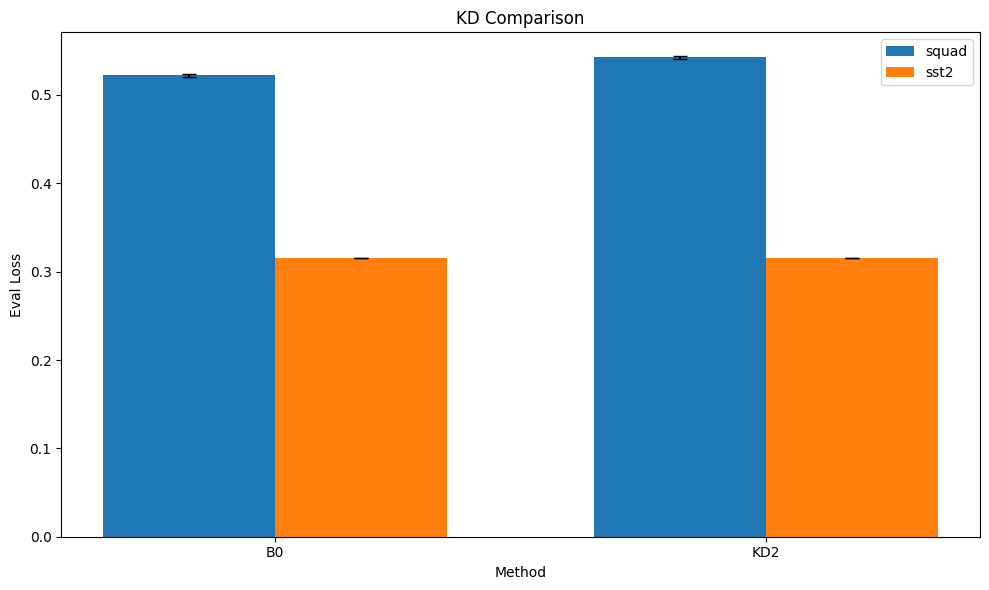

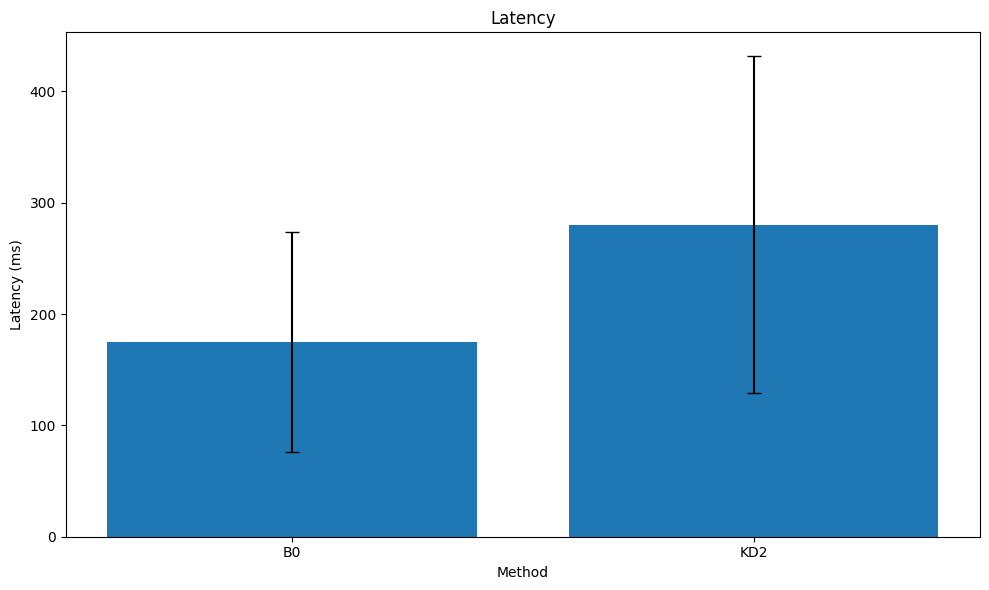

In [18]:
import matplotlib.pyplot as plt
FIGS = ROOT / 'figures'
df = pd.read_csv(RUNS / 'results.csv')
dbench = pd.read_csv(RUNS / 'benchmarks.csv')

# Method comparison
fig, ax = plt.subplots(figsize=(10, 6))
s = df.groupby(['method', 'task'])['eval_loss'].agg(['mean', 'std']).reset_index()
x = np.arange(len(s['method'].unique()))
w = 0.35
for i, t in enumerate(s['task'].unique()):
    td = s[s['task'] == t]
    ax.bar(x + i*w, td['mean'], w, yerr=td['std'], label=t, capsize=5)
ax.set_xlabel('Method'); ax.set_ylabel('Eval Loss'); ax.set_title('KD Comparison')
ax.set_xticks(x + w/2); ax.set_xticklabels(s['method'].unique()); ax.legend()
plt.tight_layout(); plt.savefig(FIGS / 'method_comparison.png', dpi=300); plt.show()

# Latency
fig, ax = plt.subplots(figsize=(10, 6))
dbench['method'] = dbench['id'].apply(lambda x: x.split('_')[0])
ls = dbench.groupby('method')['lat_mean'].agg(['mean', 'std']).reset_index()
ax.bar(ls['method'], ls['mean'], yerr=ls['std'], capsize=5)
ax.set_xlabel('Method'); ax.set_ylabel('Latency (ms)'); ax.set_title('Latency')
plt.tight_layout(); plt.savefig(FIGS / 'latency.png', dpi=300); plt.show()

## Step 7: Save to Google Drive

In [19]:
import shutil
DRIVE = Path(PROJECT_DIR) / 'results'
DRIVE.mkdir(parents=True, exist_ok=True)
for sub in ['runs', 'figures']:
    if (ROOT / sub).exists(): shutil.copytree(ROOT / sub, DRIVE / sub, dirs_exist_ok=True)
print(f'Saved to: {DRIVE}')
print('='*60)
print('EXPERIMENT COMPLETE!')
print('='*60)

Saved to: /content/drive/MyDrive/thesis-kd/results
EXPERIMENT COMPLETE!
